In [2]:
# %%
%pip install numpy
%pip install pandas
%pip install scipy

import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from lemniscate import lemniscate
from dmp import DMP
from rhytmic_dmp import RhythmicDMP
from evaluate_trajectory import evaluate_trajectory

In [ ]:
# %%
# Reference lemniscate trajectory
T, Y_ref, dY_ref, pitch_profile, dt = lemniscate(
    T=10.0,
    dt=0.02,
    a=0.08,
    center=(0.30, 0.0, 0.5),
    close_loop=True,
    rock_z_amp=0.01,
    rock_pitch_amp_deg=8.0,
    rock_phase_mult=1.0,
)

print("Reference shape:", Y_ref.shape, "dt =", dt)

Reference shape: (501, 3) dt = 0.02


In [ ]:
# %%
# Directory where full trajectories will be saved
out_dir = "dmp_sweep_results"
os.makedirs(out_dir, exist_ok=True)

n_bfs_list   = [25, 35, 45]
alpha_s_list = [2.0, 3.5]
alpha_z_list = [15.0, 25.0]
lam_list     = [1e-6, 1e-4, 1e-2]

print("Total combinations:",
      len(n_bfs_list) * len(alpha_s_list) * len(alpha_z_list) * len(lam_list))# %%
results = []

for n_bfs, alpha_s, alpha_z, lam in itertools.product(
    n_bfs_list, alpha_s_list, alpha_z_list, lam_list
):
    print(f"Running DMP with n_bfs={n_bfs}, alpha_s={alpha_s}, alpha_z={alpha_z}, lam={lam}")

    # 1) Fit DMP
    dmp = RhythmicDMP(
        n_dims=3,
        n_bfs=n_bfs,
        alpha_z=alpha_z,
        #alpha_s=alpha_s,
        lam=lam,
    )

    dmp.fit(T, Y_ref, dY_ref, dt)

    # 2) Rollout
    Y_dmp = dmp.rollout(T, dt)

    # 3) Build DataFrame and save trajectory CSV
    df = pd.DataFrame(
        np.column_stack([
            T,
            Y_ref,
            Y_dmp,
        ]),
        columns=[
            "t",
            "ref_x", "ref_y", "ref_z",
            "dmp_x", "dmp_y", "dmp_z",
        ],
    )

    lam_str = f"{lam:.0e}"  # e.g. '1e-04'
    fname = f"dmp_nbf{n_bfs}_as{alpha_s}_az{alpha_z}_lam{lam_str}.csv"
    fpath = os.path.join(out_dir, fname)
    df.to_csv(fpath, index=False)

    # 4) Evaluate similarity
    metrics = evaluate_trajectory(Y_ref, Y_dmp)
    metrics.update({
        "n_bfs": n_bfs,
        #"alpha_s": alpha_s,
        "alpha_z": alpha_z,
        "lam": lam,
        "csv_path": fpath,
    })
    results.append(metrics)

# Convert all metrics to a summary table
summary_df = pd.DataFrame(results)
summary_df.to_csv(os.path.join(out_dir, "dmp_sweep_summary.csv"), index=False)


Total combinations: 36
Running DMP with n_bfs=25, alpha_s=2.0, alpha_z=15.0, lam=1e-06
Running DMP with n_bfs=25, alpha_s=2.0, alpha_z=15.0, lam=0.0001
Running DMP with n_bfs=25, alpha_s=2.0, alpha_z=15.0, lam=0.01
Running DMP with n_bfs=25, alpha_s=2.0, alpha_z=25.0, lam=1e-06
Running DMP with n_bfs=25, alpha_s=2.0, alpha_z=25.0, lam=0.0001
Running DMP with n_bfs=25, alpha_s=2.0, alpha_z=25.0, lam=0.01
Running DMP with n_bfs=25, alpha_s=3.5, alpha_z=15.0, lam=1e-06
Running DMP with n_bfs=25, alpha_s=3.5, alpha_z=15.0, lam=0.0001
Running DMP with n_bfs=25, alpha_s=3.5, alpha_z=15.0, lam=0.01
Running DMP with n_bfs=25, alpha_s=3.5, alpha_z=25.0, lam=1e-06
Running DMP with n_bfs=25, alpha_s=3.5, alpha_z=25.0, lam=0.0001
Running DMP with n_bfs=25, alpha_s=3.5, alpha_z=25.0, lam=0.01
Running DMP with n_bfs=35, alpha_s=2.0, alpha_z=15.0, lam=1e-06
Running DMP with n_bfs=35, alpha_s=2.0, alpha_z=15.0, lam=0.0001
Running DMP with n_bfs=35, alpha_s=2.0, alpha_z=15.0, lam=0.01
Running DMP with 

In [ ]:
# %%
# Sort by RMS error ascending
summary_sorted = summary_df.sort_values("rms_error")
summary_sorted.head(10)

,rms_error,max_error,corr_x,corr_y,corr_z,cov_trace,n_bfs,alpha_z,lam,csv_path
33,0.001007,0.001676,0.999923,0.999682,0.999923,0.087196,45,25.0,0.000001,dmp_sweep_results/dmp_nbf45_as3.5_az25.0_lam1e...
27,0.001007,0.001676,0.999923,0.999682,0.999923,0.087196,45,25.0,0.000001,dmp_sweep_results/dmp_nbf45_as2.0_az25.0_lam1e...
34,0.001007,0.001676,0.999923,0.999682,0.999923,0.087196,45,25.0,0.000100,dmp_sweep_results/dmp_nbf45_as3.5_az25.0_lam1e...
28,0.001007,0.001676,0.999923,0.999682,0.999923,0.087196,45,25.0,0.000100,dmp_sweep_results/dmp_nbf45_as2.0_az25.0_lam1e...
30,0.001010,0.001576,0.999927,0.999679,0.999927,0.087200,45,15.0,0.000001,dmp_sweep_results/dmp_nbf45_as3.5_az15.0_lam1e...
24,0.001010,0.001576,0.999927,0.999679,0.999927,0.087200,45,15.0,0.000001,dmp_sweep_results/dmp_nbf45_as2.0_az15.0_lam1e...
25,0.001010,0.001576,0.999927,0.999679,0.999927,0.087200,45,15.0,0.000100,dmp_sweep_results/dmp_nbf45_as2.0_az15.0_lam1e...
31,0.001010,0.001576,0.999927,0.999679,0.999927,0.087200,45,15.0,0.000100,dmp_sweep_results/dmp_nbf45_as3.5_az15.0_lam1e...
35,0.001013,0.001684,0.999923,0.999682,0.999923,0.087194,45,25.0,0.010000,dmp_sweep_results/dmp_nbf45_as3.5_az25.0_lam1e...
29,0.001013,0.001684,0.999923,0.999682,0.999923,0.087194,45,25.0,0.010000,dmp_sweep_results/dmp_nbf45_as2.0_az25.0_lam1e...


In [ ]:
# %%
# good candidates with high correlation on all axes
good_candidates = summary_sorted[
    (summary_sorted["corr_x"] > 0.98) &
    (summary_sorted["corr_y"] > 0.98) &
    (summary_sorted["corr_z"] > 0.98)
].head(10)

good_candidates

,rms_error,max_error,corr_x,corr_y,corr_z,cov_trace,n_bfs,alpha_z,lam,csv_path
33,0.001007,0.001676,0.999923,0.999682,0.999923,0.087196,45,25.0,0.000001,dmp_sweep_results/dmp_nbf45_as3.5_az25.0_lam1e...
27,0.001007,0.001676,0.999923,0.999682,0.999923,0.087196,45,25.0,0.000001,dmp_sweep_results/dmp_nbf45_as2.0_az25.0_lam1e...
34,0.001007,0.001676,0.999923,0.999682,0.999923,0.087196,45,25.0,0.000100,dmp_sweep_results/dmp_nbf45_as3.5_az25.0_lam1e...
28,0.001007,0.001676,0.999923,0.999682,0.999923,0.087196,45,25.0,0.000100,dmp_sweep_results/dmp_nbf45_as2.0_az25.0_lam1e...
30,0.001010,0.001576,0.999927,0.999679,0.999927,0.087200,45,15.0,0.000001,dmp_sweep_results/dmp_nbf45_as3.5_az15.0_lam1e...
24,0.001010,0.001576,0.999927,0.999679,0.999927,0.087200,45,15.0,0.000001,dmp_sweep_results/dmp_nbf45_as2.0_az15.0_lam1e...
25,0.001010,0.001576,0.999927,0.999679,0.999927,0.087200,45,15.0,0.000100,dmp_sweep_results/dmp_nbf45_as2.0_az15.0_lam1e...
31,0.001010,0.001576,0.999927,0.999679,0.999927,0.087200,45,15.0,0.000100,dmp_sweep_results/dmp_nbf45_as3.5_az15.0_lam1e...
35,0.001013,0.001684,0.999923,0.999682,0.999923,0.087194,45,25.0,0.010000,dmp_sweep_results/dmp_nbf45_as3.5_az25.0_lam1e...
29,0.001013,0.001684,0.999923,0.999682,0.999923,0.087194,45,25.0,0.010000,dmp_sweep_results/dmp_nbf45_as2.0_az25.0_lam1e...


Saved: dmp_sweep_results/all_dmp_vs_ref.png


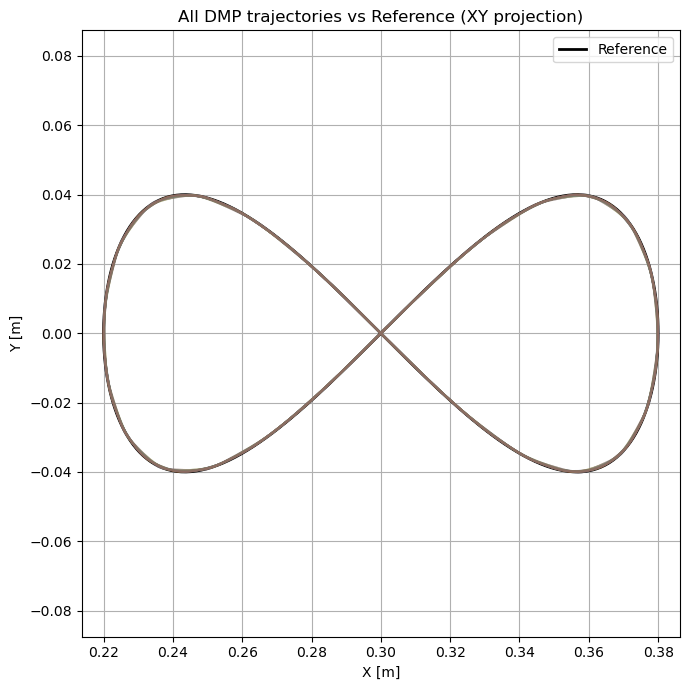

In [ ]:
summary_path = os.path.join(out_dir, "dmp_sweep_summary.csv")
summary_df = pd.read_csv(summary_path)

# ---- Plot ALL trajectories vs reference ----
plt.figure(figsize=(7, 7))

# Plot reference once
plt.plot(Y_ref[:, 0], Y_ref[:, 1], label="Reference", linewidth=2, color="black")

# Plot every DMP trajectory
for _, row in summary_df.iterrows():
    df_run = pd.read_csv(row["csv_path"])
    plt.plot(df_run["dmp_x"], df_run["dmp_y"], alpha=0.20)

plt.title("All DMP trajectories vs Reference (XY projection)")
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.axis("equal")
plt.grid(True)
plt.legend()
plt.tight_layout()

all_plot_path = os.path.join(out_dir, "all_dmp_vs_ref.png")
plt.savefig(all_plot_path, dpi=300)
print(f"Saved: {all_plot_path}")
plt.show()

In [ ]:
# %%
# Find best configuration based on RMS error
best_row = summary_df.sort_values("rms_error").iloc[0]
print("Best configuration:")
print(best_row[["n_bfs", "alpha_s", "alpha_z", "lam", "rms_error"]])

df_best = pd.read_csv(best_row["csv_path"])

# ---- XY plot of best vs reference ----
plt.figure(figsize=(7, 7))
plt.plot(df_best["ref_x"], df_best["ref_y"], label="Reference", linewidth=2, color="black")
plt.plot(df_best["dmp_x"], df_best["dmp_y"], label="Best DMP", linestyle="--", color="red")

plt.title("Best DMP vs Reference (XY)")
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.axis("equal")
plt.grid(True)
plt.legend()
plt.tight_layout()

best_xy_path = os.path.join(out_dir, "best_dmp_xy_vs_ref.png")
plt.savefig(best_xy_path, dpi=300)
print(f"Saved: {best_xy_path}")
plt.show()


# ---- Time-series comparison ----
plt.figure(figsize=(10, 7))

# X
plt.subplot(3,1,1)
plt.plot(df_best["t"], df_best["ref_x"], label="ref_x")
plt.plot(df_best["t"], df_best["dmp_x"], label="dmp_x", linestyle="--")
plt.ylabel("X [m]")
plt.grid(True)
plt.legend()

# Y
plt.subplot(3,1,2)
plt.plot(df_best["t"], df_best["ref_y"], label="ref_y")
plt.plot(df_best["t"], df_best["dmp_y"], label="dmp_y", linestyle="--")
plt.ylabel("Y [m]")
plt.grid(True)
plt.legend()

# Z
plt.subplot(3,1,3)
plt.plot(df_best["t"], df_best["ref_z"], label="ref_z")
plt.plot(df_best["t"], df_best["dmp_z"], label="dmp_z", linestyle="--")
plt.xlabel("t [s]")
plt.ylabel("Z [m]")
plt.grid(True)
plt.legend()

plt.tight_layout()

best_ts_path = os.path.join(out_dir, "best_dmp_time_series.png")
plt.savefig(best_ts_path, dpi=300)
print(f"Saved: {best_ts_path}")
plt.show()

Best configuration:


<class 'KeyError'>: "['alpha_s'] not in index"

In [ ]:
# %%
import os
import zipfile

zip_path = "dmp_sweep_results.zip"

if os.path.exists(zip_path):
    os.remove(zip_path)

with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(out_dir):
        for file in files:
            abs_path = os.path.join(root, file)
            rel_path = os.path.relpath(abs_path, out_dir)  # keep clean folder structure
            zipf.write(abs_path, arcname=os.path.join("dmp_sweep_results", rel_path))

print(f"✔ Zipped sweep folder into: {zip_path}")
